In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
from src.Dataset_loader import CustomImageDataset
import matplotlib.pyplot as plt
import time
from src.models import ConvNet_1
from src.utils import set_seed
import torch.optim as optim
import torch.nn as nn
from src.utils import show
from src.utils import class_number_to_name
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
torch.__version__

'2.3.1+cu121'

In [3]:
train_set = CustomImageDataset()
validation_set = CustomImageDataset()
test_set = CustomImageDataset()

train_set.load_batch('data/cifar-10-batches-py/data_batch_1')
train_set.load_batch('data/cifar-10-batches-py/data_batch_2')
train_set.load_batch('data/cifar-10-batches-py/data_batch_3')
train_set.load_batch('data/cifar-10-batches-py/data_batch_4')
validation_set.load_batch('data/cifar-10-batches-py/data_batch_5')

test_set.load_batch('data/cifar-10-batches-py/test_batch')

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                         shuffle=True, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32,
                                         shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=True, pin_memory=True)

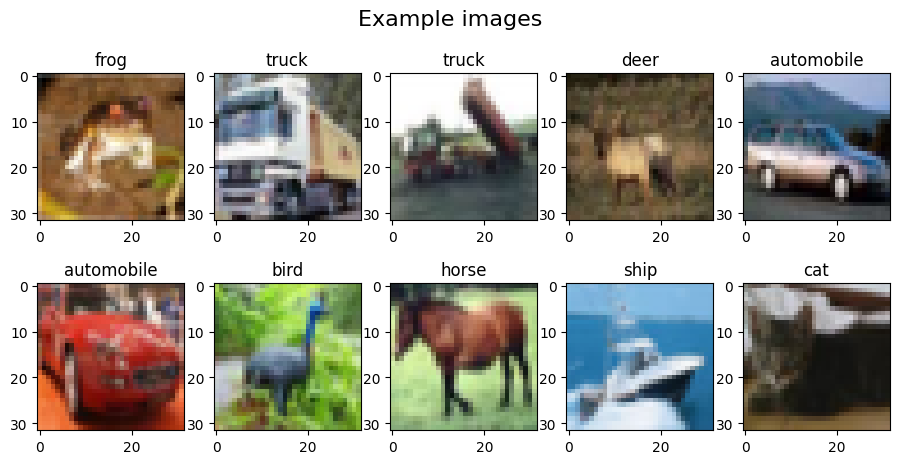

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(11,5))
fig.suptitle("Example images", fontsize=16)
for i in range(10):
    if i < 5:
        show(train_set[i], axs[0,i])
    else:
        show(train_set[i], axs[1,i - 5])

# Simple convolutional net

In [6]:
from src.models import ConvNet_1
from src.utils import set_seed
import torch.optim as optim
import torch.nn as nn
import time

set_seed(42)
net = ConvNet_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters())

epochs = np.arange(1, 51)
losses_train = list()
losses_val = list()

In [6]:
# Training process

current_time = time.time()
best_val_loss = float('inf')
for epoch in epochs:  # loop over the dataset multiple times
    epoch_loss_train = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss_train += loss.item()
        if i % 500 == 499:    # Print every 500 mini-batches
            print(f"Current time of execution: {round(time.time() - current_time, 0)} s, epoch: {epoch}/{epochs[-1]}, minibatch: {i + 1:5d}/{len(train_loader)}, loss: {running_loss / 500:.3f}")
            running_loss = 0.0
    epoch_loss_val = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_loss_val += loss.item()
    if epoch_loss_val < best_val_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses_train,
            'val_loss': losses_val
        }, 'conv_net_1_best_performance.pth')
        best_val_loss = epoch_loss_val
    losses_train.append(epoch_loss_train/len(train_loader))
    losses_val.append(epoch_loss_val/len(validation_loader))

torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses_train,
            'val_loss': losses_val
        }, 'conv_net_1_full_training.pth') 

print('Finished Training')


Current time of execution: 13.0 s, epoch: 1/50, minibatch:   500/1250, loss: 2.234
Current time of execution: 27.0 s, epoch: 1/50, minibatch:  1000/1250, loss: 2.012
Current time of execution: 49.0 s, epoch: 2/50, minibatch:   500/1250, loss: 1.780
Current time of execution: 62.0 s, epoch: 2/50, minibatch:  1000/1250, loss: 1.712
Current time of execution: 84.0 s, epoch: 3/50, minibatch:   500/1250, loss: 1.616
Current time of execution: 96.0 s, epoch: 3/50, minibatch:  1000/1250, loss: 1.586
Current time of execution: 118.0 s, epoch: 4/50, minibatch:   500/1250, loss: 1.530
Current time of execution: 131.0 s, epoch: 4/50, minibatch:  1000/1250, loss: 1.501
Current time of execution: 154.0 s, epoch: 5/50, minibatch:   500/1250, loss: 1.455
Current time of execution: 167.0 s, epoch: 5/50, minibatch:  1000/1250, loss: 1.462
Current time of execution: 189.0 s, epoch: 6/50, minibatch:   500/1250, loss: 1.422
Current time of execution: 202.0 s, epoch: 6/50, minibatch:  1000/1250, loss: 1.40

ValueError: x and y must have same first dimension, but have shapes (50,) and (17,)

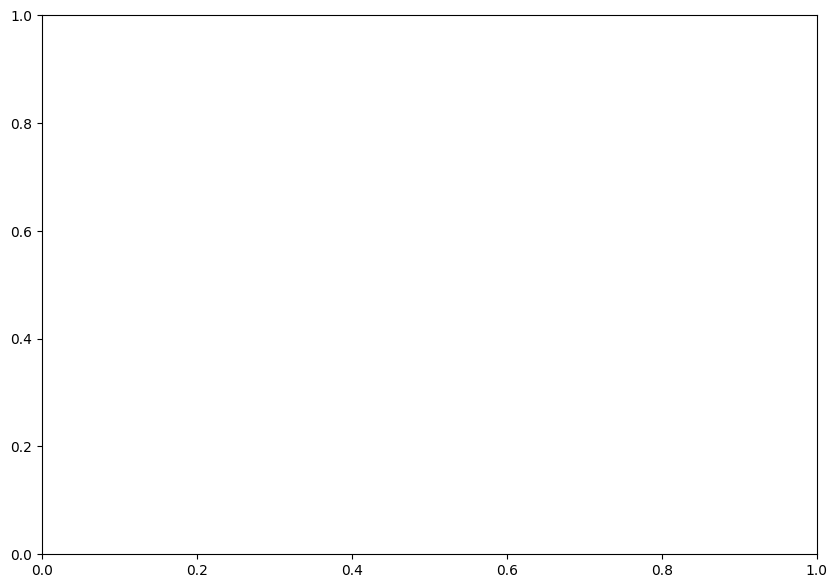

In [8]:
plt.figure(figsize=(10,7))
marker_on = [losses_val.index(min(losses_val))]
plt.plot(epochs, losses_train, color='r', label="Train loss")
plt.plot(epochs, losses_val, '-gD', label="Test loss", markevery=marker_on)
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate(text=f"Min loss after {losses_val.index(min(losses_val))+1} epohs", xy=(losses_val.index(min(losses_val))+1, min(losses_val)), xytext =(losses_val.index(min(losses_val))+1, min(losses_val)+0.05),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.2),bbox=bbox)
plt.grid()
plt.title(f"Train and Val loss after {epochs[-1]} epochs")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropyLoss")
plt.legend(loc='upper left');

In [7]:
best_model = torch.load('conv_net_1_best_performance.pth')
net = ConvNet_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters())
net.load_state_dict(best_model['model_state_dict'])
optimizer.load_state_dict(best_model['optimizer_state_dict'])
epoch = best_model['epoch']
losses_train = best_model['train_loss']
losses_val = best_model['val_loss']

In [9]:
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
print("Loss on the test set:", test_loss/len(test_loader))

Loss on the test set: 1.2443265593089996


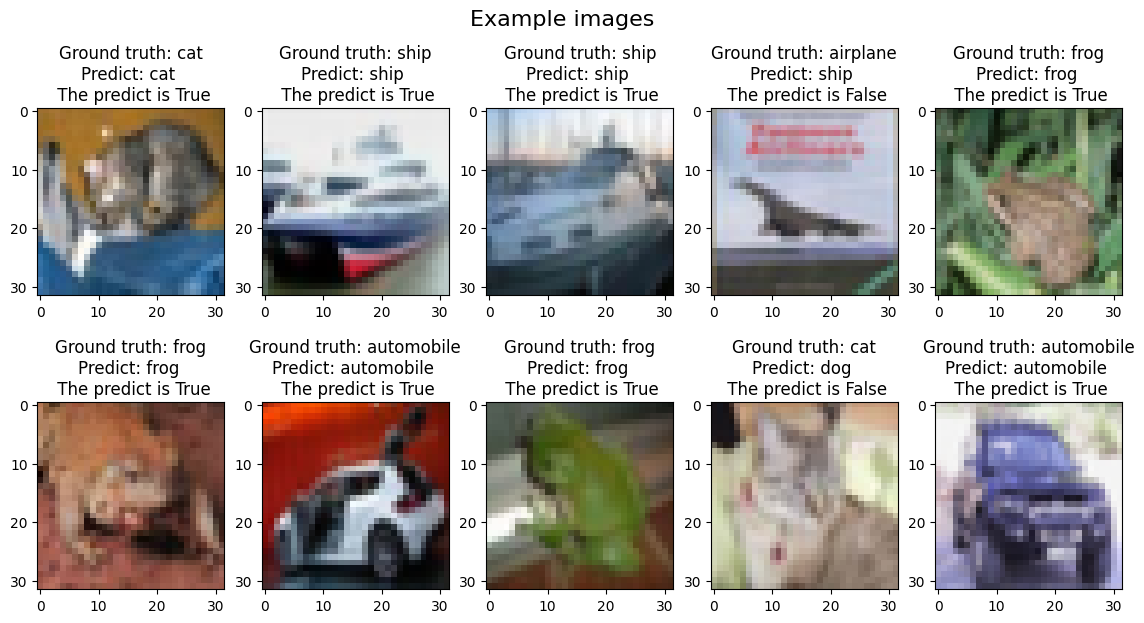

In [33]:
fig, axs = plt.subplots(2, 5, figsize=(14,7))
fig.suptitle("Example images", fontsize=16)
for i in range(10):
    image, label = test_set[i]
    output = net(image)
    if i < 5:
        show(test_set[i], axs[0,i], title=f"Ground truth: {class_number_to_name[label]}\nPredict: {class_number_to_name[int(torch.argmax(output))]} \n The predict is {class_number_to_name[label] ==class_number_to_name[int(torch.argmax(output))]}")
    else:
        show(test_set[i], axs[1,i - 5], title=f"Ground truth: {class_number_to_name[label]}\nPredict: {class_number_to_name[int(torch.argmax(output))]} \n The predict is {class_number_to_name[label] ==class_number_to_name[int(torch.argmax(output))]}")

In [26]:
total_correct = 0
total_samples = 0

for images, labels in test_loader:

        # Forward pass
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        # Update the running total of correct predictions and samples
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate the accuracy for this epoch
accuracy = 100 * total_correct / total_samples
print(f'Accuracy = {accuracy:.2f}%')

Accuracy = 56.72%


# More complex convolutional net

In [12]:
from src.models import ConvNet_2
from src.utils import set_seed
import torch.optim as optim
import torch.nn as nn
import time
import numpy as np

set_seed(42)
net = ConvNet_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())

epochs = np.arange(1, 51)
losses_train = list()
losses_val = list()

In [13]:
# Training process

current_time = time.time()
best_val_loss = float('inf')
for epoch in epochs:  # loop over the dataset multiple times
    epoch_loss_train = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss_train += loss.item()
        if i % 500 == 499:    # Print every 500 mini-batches
            print(f"Current time of execution: {round(time.time() - current_time, 0)} s, epoch: {epoch}/{epochs[-1]}, minibatch: {i + 1:5d}/{len(train_loader)}, loss: {running_loss / 500:.3f}")
            running_loss = 0.0
    epoch_loss_val = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_loss_val += loss.item()
    if epoch_loss_val < best_val_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses_train,
            'val_loss': losses_val
        }, 'conv_net_2_best_performance.pth')
        best_val_loss = epoch_loss_val
    losses_train.append(epoch_loss_train/len(train_loader))
    losses_val.append(epoch_loss_val/len(validation_loader))

torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses_train,
            'val_loss': losses_val
        }, 'conv_net_2_full_training.pth') 

print('Finished Training')

Current time of execution: 28.0 s, epoch: 1/50, minibatch:   500/1250, loss: 1.617
Current time of execution: 60.0 s, epoch: 1/50, minibatch:  1000/1250, loss: 1.318
Current time of execution: 117.0 s, epoch: 2/50, minibatch:   500/1250, loss: 1.114
Current time of execution: 150.0 s, epoch: 2/50, minibatch:  1000/1250, loss: 1.049
Current time of execution: 208.0 s, epoch: 3/50, minibatch:   500/1250, loss: 0.947
Current time of execution: 241.0 s, epoch: 3/50, minibatch:  1000/1250, loss: 0.925
Current time of execution: 299.0 s, epoch: 4/50, minibatch:   500/1250, loss: 0.826
Current time of execution: 333.0 s, epoch: 4/50, minibatch:  1000/1250, loss: 0.830
Current time of execution: 391.0 s, epoch: 5/50, minibatch:   500/1250, loss: 0.743
Current time of execution: 425.0 s, epoch: 5/50, minibatch:  1000/1250, loss: 0.749
Current time of execution: 486.0 s, epoch: 6/50, minibatch:   500/1250, loss: 0.663
Current time of execution: 521.0 s, epoch: 6/50, minibatch:  1000/1250, loss: 

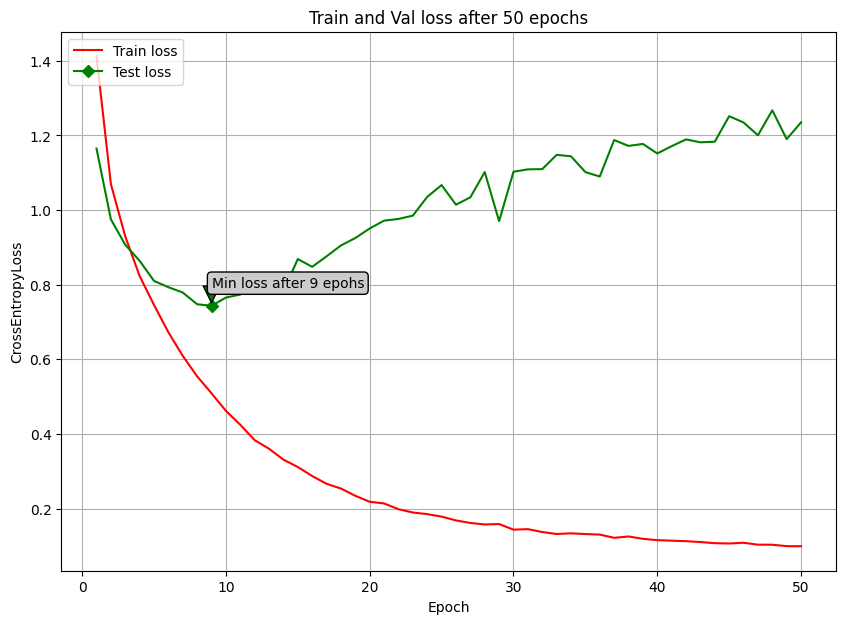

In [14]:
plt.figure(figsize=(10,7))
marker_on = [losses_val.index(min(losses_val))]
plt.plot(epochs, losses_train, color='r', label="Train loss")
plt.plot(epochs, losses_val, '-gD', label="Test loss", markevery=marker_on)
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate(text=f"Min loss after {losses_val.index(min(losses_val))+1} epohs", xy=(losses_val.index(min(losses_val))+1, min(losses_val)), xytext =(losses_val.index(min(losses_val))+1, min(losses_val)+0.05),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.2),bbox=bbox)
plt.grid()
plt.title(f"Train and Val loss after {epochs[-1]} epochs")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropyLoss")
plt.legend(loc='upper left');

In [15]:
best_model = torch.load('conv_net_2_best_performance.pth')
net = ConvNet_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())
net.load_state_dict(best_model['model_state_dict'])
optimizer.load_state_dict(best_model['optimizer_state_dict'])
epoch = best_model['epoch']
losses_train = best_model['train_loss']
losses_val = best_model['val_loss']

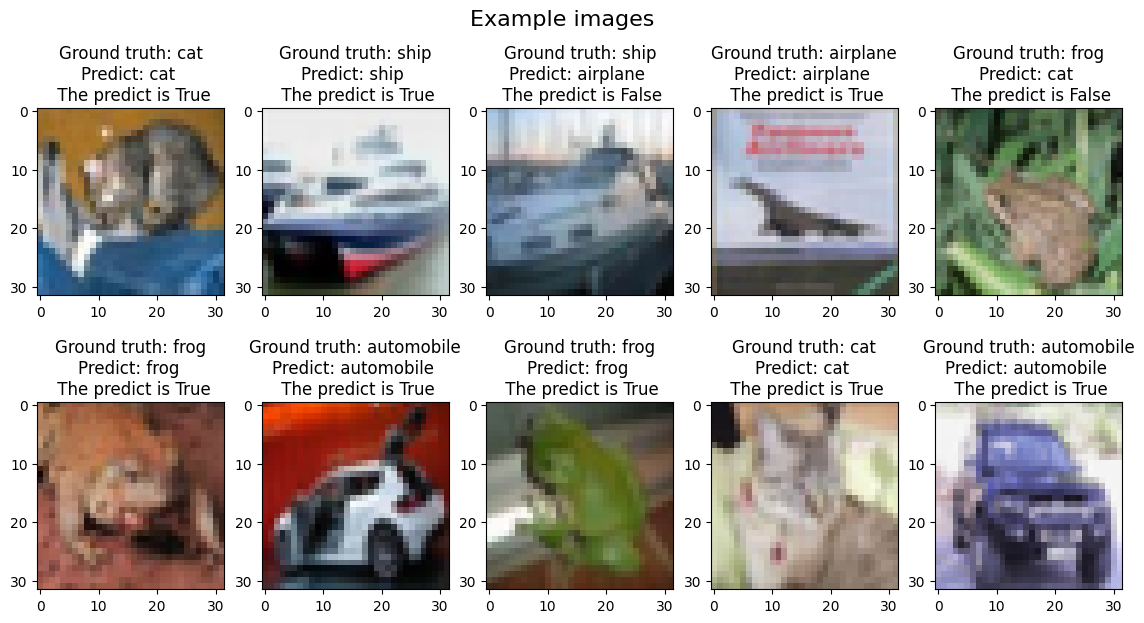

In [38]:
fig, axs = plt.subplots(2, 5, figsize=(14,7))
fig.suptitle("Example images", fontsize=16)
for i in range(10):
    image, label = test_set[i]
    output = net(image.view(1, 3, 32, 32))
    if i < 5:
        show(test_set[i], axs[0,i], title=f"Ground truth: {class_number_to_name[label]}\nPredict: {class_number_to_name[int(torch.argmax(output))]} \n The predict is {class_number_to_name[label] ==class_number_to_name[int(torch.argmax(output))]}")
    else:
        show(test_set[i], axs[1,i - 5], title=f"Ground truth: {class_number_to_name[label]}\nPredict: {class_number_to_name[int(torch.argmax(output))]} \n The predict is {class_number_to_name[label] ==class_number_to_name[int(torch.argmax(output))]}")

In [39]:
total_correct = 0
total_samples = 0

for images, labels in test_loader:

        # Forward pass
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        # Update the running total of correct predictions and samples
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate the accuracy for this epoch
accuracy = 100 * total_correct / total_samples
print(f'Accuracy = {accuracy:.2f}%')

Accuracy = 74.66%
